<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/ETA-Prediction/ETA_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
upload = files.upload()

Saving 218 Datasets.csv to 218 Datasets (3).csv


Load Data

In [ ]:
df = pd.read_csv('/content/218 Datasets.csv')
df.head()

,Trip,Route No,Kataragama (Departure),Thissamaharama,Debarawewa,Weerawila,Lunugamwehera,Thanamanwila,Wellawaya,Buttala,...,Habarana,Maradankadawala,Anuradhapura,Medawachiya,Vavuniya,Kilinochi,Elephant Pass,Kodikamam,Jaffna,Incidents
0,1,218,19:22,20:07,20:20,20:35,21:01,21:20,22:03,22:23,...,3:32,3:55,4:30,4:56,5:36,6:11,6:40,6:54,7:56,NaN
1,2,218,19:19,20:10,20:19,20:36,20:58,21:13,22:05,22:26,...,3:28,3:53,4:35,4:57,5:34,6:13,6:40,6:57,7:58,NaN
2,3,218,19:24,20:09,20:22,20:33,21:01,21:10,22:03,22:23,...,3:30,3:49,4:32,4:56,5:32,6:13,6:48,6:58,7:51,NaN
3,4,218,19:26,20:06,20:17,20:28,20:56,21:18,22:06,22:27,...,3:28,3:55,4:33,5:01,5:32,6:11,6:40,6:57,7:57,NaN
4,5,218,19:24,20:07,20:19,20:29,21:01,21:12,22:03,22:25,...,3:29,3:56,4:31,5:04,5:37,6:08,6:46,6:59,7:58,NaN


Preprocessing (Convert Times)

In [ ]:
df = pd.read_csv('/content/218 Datasets.csv') # Reload df to ensure original string format

# Identify time columns (between Route No and Incidents)
time_cols = df.columns[2:-1]

print("Detected Stops:")
for s in time_cols:
    print(s)

# Convert all time columns to datetime, handling overnight journeys
for i, col in enumerate(time_cols):
    df[col] = pd.to_datetime(df[col].astype(str), format="%H:%M")

    # If it's not the first stop, check if the current time is before the previous stop's time
    if i > 0:
        prev_col = time_cols[i-1]
        # For each row, if current stop time is less than previous stop time, add 1 day
        # This assumes trips do not span more than one midnight between consecutive stops
        df.loc[df[col] < df[prev_col], col] += pd.Timedelta(days=1)

Detected Stops:
Kataragama (Departure)
Thissamaharama
Debarawewa
Weerawila
Lunugamwehera
Thanamanwila
Wellawaya
Buttala
Monaragala
Medagama
Bibila
Mahiyangana
Nidangala
Dehiyathakandiya
Siripura
Dalupahana
Kaduruwela
Polonnaruwa
Habarana
Maradankadawala
Anuradhapura
Medawachiya
Vavuniya
Kilinochi
Elephant Pass
Kodikamam
Jaffna


Feature Engineering (Stop Durations + Time Features)

In [ ]:
# Duration between stops
duration_features = []

for i in range(len(time_cols) - 1):
    start = time_cols[i]
    end = time_cols[i + 1]
    dcol = f"Dur_{start}_{end}"
    df[dcol] = (df[end] - df[start]).dt.total_seconds() / 60
    duration_features.append(dcol)

# Target = total trip duration
df["ETA_Final"] = (df[time_cols[-1]] - df[time_cols[0]]).dt.total_seconds() / 60

# Start time features
df["start_hour"] = df[time_cols[0]].dt.hour
df["is_peak"] = df["start_hour"].isin([6,7,8,16,17,18]).astype(int)

df.head()

,Trip,Route No,Kataragama (Departure),Thissamaharama,Debarawewa,Weerawila,Lunugamwehera,Thanamanwila,Wellawaya,Buttala,...,Dur_Maradankadawala_Anuradhapura,Dur_Anuradhapura_Medawachiya,Dur_Medawachiya_Vavuniya,Dur_Vavuniya_Kilinochi,Dur_Kilinochi_Elephant Pass,Dur_Elephant Pass_Kodikamam,Dur_Kodikamam_Jaffna,ETA_Final,start_hour,is_peak
0,1,218,1900-01-01 19:22:00,1900-01-01 20:07:00,1900-01-01 20:20:00,1900-01-01 20:35:00,1900-01-01 21:01:00,1900-01-01 21:20:00,1900-01-01 22:03:00,1900-01-01 22:23:00,...,35.0,26.0,40.0,35.0,29.0,14.0,62.0,-686.0,19,0
1,2,218,1900-01-01 19:19:00,1900-01-01 20:10:00,1900-01-01 20:19:00,1900-01-01 20:36:00,1900-01-01 20:58:00,1900-01-01 21:13:00,1900-01-01 22:05:00,1900-01-01 22:26:00,...,42.0,22.0,37.0,39.0,27.0,17.0,61.0,-681.0,19,0
2,3,218,1900-01-01 19:24:00,1900-01-01 20:09:00,1900-01-01 20:22:00,1900-01-01 20:33:00,1900-01-01 21:01:00,1900-01-01 21:10:00,1900-01-01 22:03:00,1900-01-01 22:23:00,...,43.0,24.0,36.0,41.0,35.0,10.0,53.0,-693.0,19,0
3,4,218,1900-01-01 19:26:00,1900-01-01 20:06:00,1900-01-01 20:17:00,1900-01-01 20:28:00,1900-01-01 20:56:00,1900-01-01 21:18:00,1900-01-01 22:06:00,1900-01-01 22:27:00,...,38.0,28.0,31.0,39.0,29.0,17.0,60.0,-689.0,19,0
4,5,218,1900-01-01 19:24:00,1900-01-01 20:07:00,1900-01-01 20:19:00,1900-01-01 20:29:00,1900-01-01 21:01:00,1900-01-01 21:12:00,1900-01-01 22:03:00,1900-01-01 22:25:00,...,35.0,33.0,33.0,31.0,38.0,13.0,59.0,-686.0,19,0


EDA

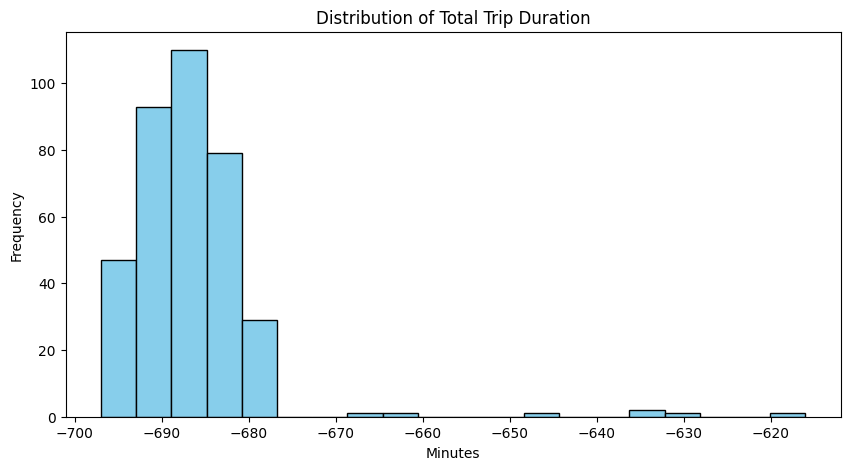

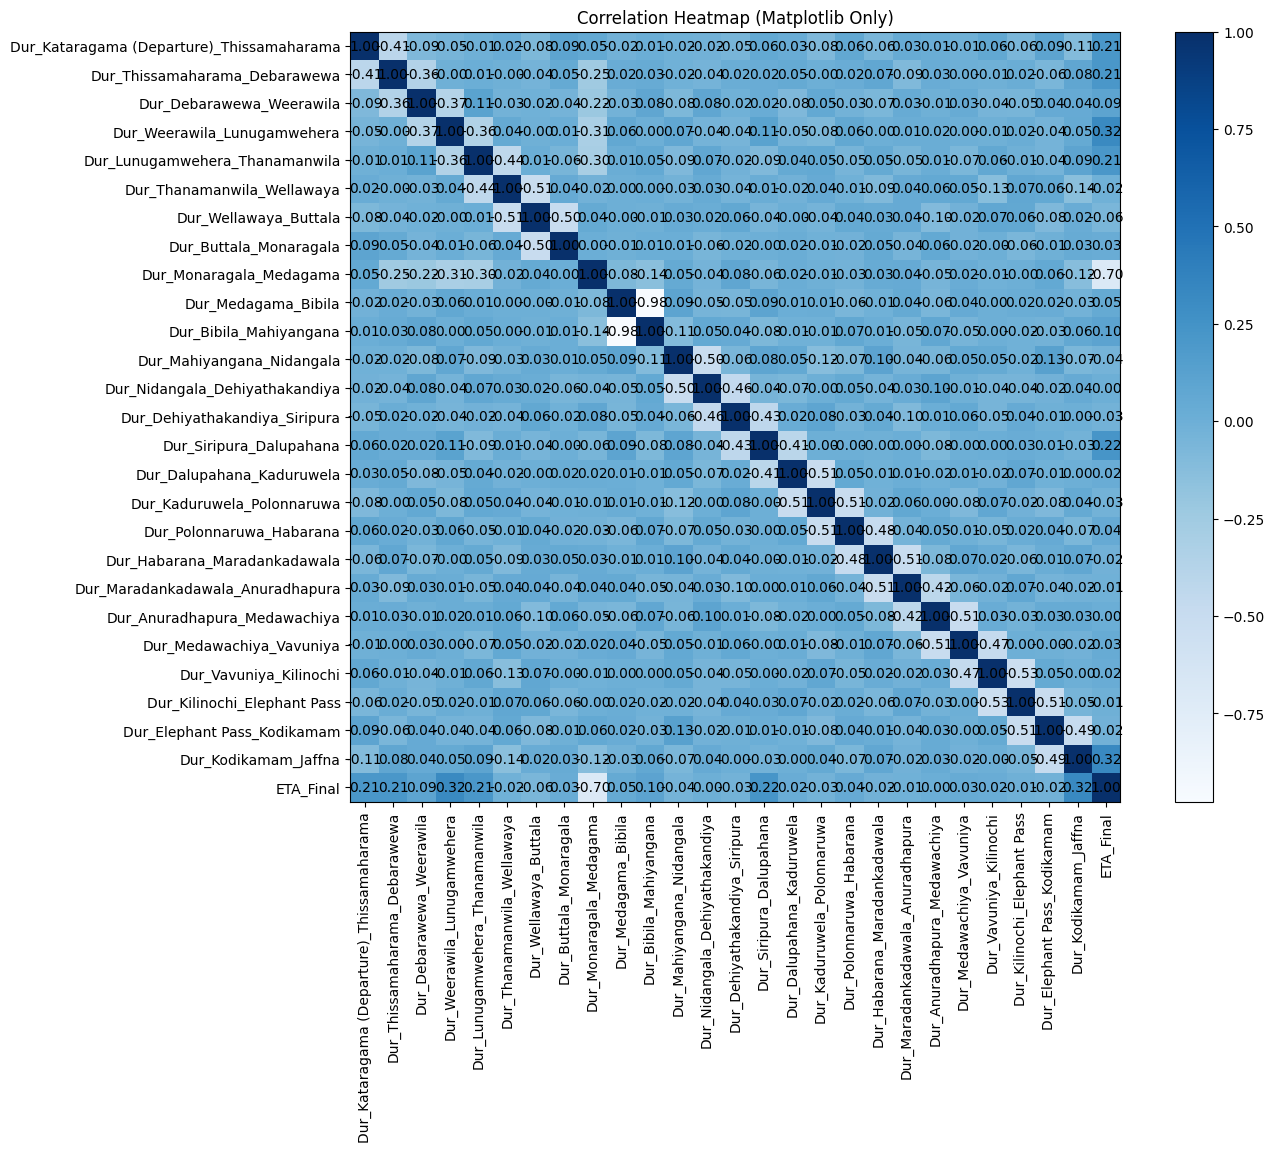

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df["ETA_Final"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Total Trip Duration")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()


# CORRELATION MATRIX (matplotlib only)
corr = df[duration_features + ["ETA_Final"]].corr()

plt.figure(figsize=(14,10))
plt.imshow(corr, cmap="Blues")
plt.colorbar()
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.columns)), labels=corr.columns)

# annotate
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center")

plt.title("Correlation Heatmap (Matplotlib Only)")
plt.show()

Train / Test Split

In [ ]:
features = duration_features + ["start_hour", "is_peak"]
target = "ETA_Final"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train XGBOOST Model

In [ ]:
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print(f"MAE (minutes): {mae:.2f}")

joblib.dump(model, "eta_218_final_xgb.pkl")

MAE (minutes): 2.66


['eta_218_final_xgb.pkl']

Make Forward + Reverse Stop Lists

In [ ]:
forward_stops = list(time_cols)
reverse_stops = forward_stops[::-1]

model = joblib.load("eta_218_final_xgb.pkl")

ETA Function

In [ ]:
def predict_eta_remaining(current_stop, current_time, pickup_stop, stop_list):

    cur_idx = stop_list.index(current_stop)
    pick_idx = stop_list.index(pickup_stop)

    if pick_idx <= cur_idx:
        return "Bus already passed pickup location.", None

    # Convert user time
    ct = pd.to_datetime(current_time, format="%H:%M")

    # Mean scheduled times of each stop
    mean_times = df[stop_list].apply(
        lambda col: pd.to_timedelta(col.dt.strftime("%H:%M:%S"))
    ).mean()

    sched_current = mean_times[current_stop]
    sched_pickup = mean_times[pickup_stop]

    # Future time (historical average)
    future_minutes = (sched_pickup - sched_current).total_seconds() / 60
    future_minutes = max(future_minutes, 0)

    arrival_time = (ct + pd.Timedelta(minutes=future_minutes)).strftime("%H:%M")

    return round(future_minutes, 2), arrival_time

User Program

In [ ]:
print("Choose Route:")
print("1. 218 — Kataragama → Jaffna")
print("2. 218 — Jaffna → Kataragama")

choice = int(input("Enter option: "))

if choice == 1:
    stop_list = forward_stops
else:
    stop_list = reverse_stops

print("\nAvailable Stops:")
for i, stop in enumerate(stop_list):
    print(f"{i+1}. {stop}")

cur_idx = int(input("\nEnter your CURRENT stop number: ")) - 1
current_stop = stop_list[cur_idx]

current_time = input("Enter CURRENT time (HH:MM): ")

pick_idx = int(input("\nEnter PICKUP stop number: ")) - 1
pickup_stop = stop_list[pick_idx]

eta_minutes, eta_time = predict_eta_remaining(current_stop, current_time, pickup_stop, stop_list)

print("\n-------------------------------------------------")
print(f"Bus will reach **{pickup_stop}** in:")
print(f"  → {eta_minutes} minutes")
print(f"  → Expected arrival time: {eta_time}")
print("-------------------------------------------------")

Choose Route:
1. 218 — Kataragama → Jaffna
2. 218 — Jaffna → Kataragama
Enter option: 1

Available Stops:
1. Kataragama (Departure)
2. Thissamaharama
3. Debarawewa
4. Weerawila
5. Lunugamwehera
6. Thanamanwila
7. Wellawaya
8. Buttala
9. Monaragala
10. Medagama
11. Bibila
12. Mahiyangana
13. Nidangala
14. Dehiyathakandiya
15. Siripura
16. Dalupahana
17. Kaduruwela
18. Polonnaruwa
19. Habarana
20. Maradankadawala
21. Anuradhapura
22. Medawachiya
23. Vavuniya
24. Kilinochi
25. Elephant Pass
26. Kodikamam
27. Jaffna

Enter your CURRENT stop number: 3
Enter CURRENT time (HH:MM): 20:30

Enter PICKUP stop number: 18

-------------------------------------------------
Bus will reach **Polonnaruwa** in:
  → 0 minutes
  → Expected arrival time: 20:30
-------------------------------------------------
